In [100]:
import sys
sys.path.append("..")

import Essentials


In [101]:
import numpy as np
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler
import Essentials
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from abc import ABC, abstractmethod

In [102]:
# Загрузка данных
data_archive = np.load('C:\\Users\\misha\\Makarov\\Data_Average.npz', allow_pickle=True)



In [103]:
def prepare_Y(y):
    timestamp = y[:, 1]   
    y = y[:, 0].reshape(len(y), 1)
    y = y.astype(np.float64)

    return y, timestamp
ALL_column_names_1 = data_archive['column_names_1'] 
all_X_1 = data_archive['all_X_1']
all_Y_1 = data_archive['all_Y_1']

ALL_column_names_2 = data_archive['column_names_2_cat'] 
all_X_2 = data_archive['all_X_2']
all_Y_2 = data_archive['all_Y_2']

ALL_column_names_3 = data_archive['column_names_3_cat']
all_X_3 = data_archive['all_X_3']
all_Y_3 = data_archive['all_Y_3']
x_train, x_test, y_train, y_test = train_test_split(all_X_1, all_Y_1, test_size=0.3, random_state=42)
y_train, timestamp_train = prepare_Y(y_train)
y_test, timestamp_test = prepare_Y(y_test)


In [104]:
class RobustLinearSoftSensor(Essentials.SoftSensor):
    def __init__(self, name, x_train, y_train, column_names):
        super().__init__(name)
        self.name = name
        self.column_names = column_names  # Добавляем список названий признаков
        self.train(x_train, y_train)  

    def preprocessing(self, x):
        return x

    def postprocessing(self, pred_values):
        if pred_values.ndim == 1:
            pred_values = pred_values.reshape(-1, 1)
        return pred_values

    def evaluate_model(self, x):
        if self.get_model() is None:
            raise ValueError("Model is not trained yet.")
        return self.get_model().predict(x)

    def train(self, x_train, y_train):
        self.set_model(HuberRegressor())
        self.get_model().fit(x_train, y_train)
        self.r2_score = self.get_model().score(x_train, y_train)
        self.coefficients = self.get_model().coef_

    def __str__(self):
        if self.get_model() is not None:
            # Форматирование названий признаков и коэффициентов для вывода
            max_len = max(len(name) for name in self.column_names)
            coefs_str = "\n".join(
                [f"{name.ljust(max_len)}: {coef:.4f}" for name, coef in zip(self.column_names, self.coefficients)]
            )
            
            return (f"Robust Linear Soft Sensor '{self.name}':\n"
                    f"Коэффициенты:\n{coefs_str}\n"
                    f"R^2 score: {self.r2_score:.4f}")
        else:
            return "Robust Linear Soft Sensor Model has not been trained yet."

In [105]:
sensor = RobustLinearSoftSensor("Robust Sensor", x_train, y_train, column_names=ALL_column_names_1)

c:\Users\misha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\misha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [106]:
print(sensor)

Robust Linear Soft Sensor 'Robust Sensor':
Коэффициенты:
Расход бензина ККР на установку           : 0.0805
Расход нафты ККР на установку             : -0.1034
Расход бензина на рециркуляцию от Е-1205  : -0.0543
Температура бензина ККР на установку      : 0.0481
Расход сырья после Р-1101                 : 0.0188
Показатель соотношения водород к углероду : 0.0019
Расход водорода на смешение перед Е-1101  : -0.0050
Температура сырья перед Е-1101            : 0.0485
Давление сырья перед Е-1101               : 0.0106
Температура сырья перед Е-1102            : 0.0024
Температура сырья перед Е-1103            : 0.0485
Давление сырья перед Е-1103               : 0.0106
Температура сырья после Е-1103            : 0.0817
Температура ТБ перед Е-1101               : 0.0051
Давление ТБ перед Е-1101                  : 0.0069
Температура ТБ после Е-1101               : 0.0087
Температура бензина перед Е-1102          : 0.0907
Температура бензина после Е-1102          : 0.0509
Давление бензина после

In [107]:
metric = Essentials.R2Metric()

In [108]:
test_visual_1 = Essentials.Visualizer(x_train, y_train, timestamp_train, [metric], 'Test SoftSensor R2 metric')

               Coefficient of determination
Robust Sensor                      0.703545


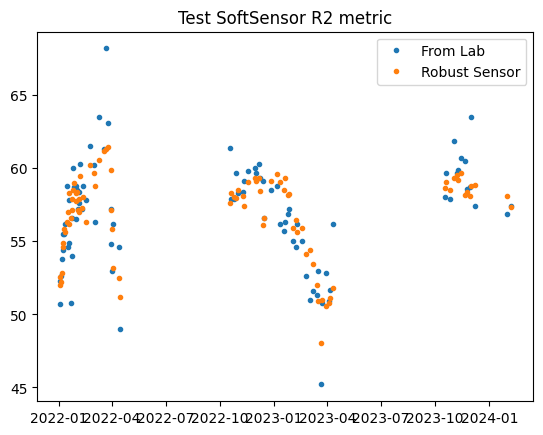

In [109]:

test_visual_1.visualize([sensor])

In [110]:
test_visual = Essentials.Visualizer(x_test, y_test, timestamp_test, [metric], 'Test SoftSensor R2 metric')

               Coefficient of determination
Robust Sensor                      0.616243


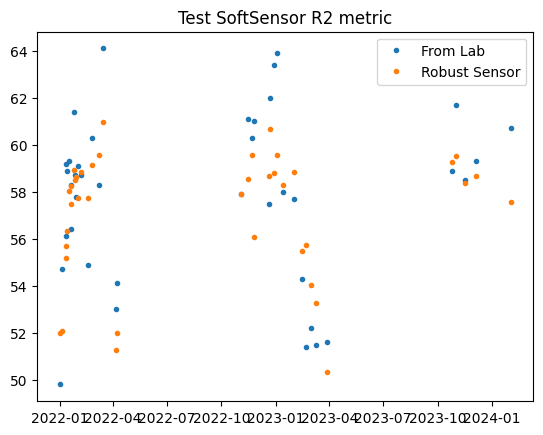

In [111]:
test_visual.visualize([sensor])